# <center>HW3</center>
### <center>106030012 廖昱瑋</center>
***

## 決定model
這次總共用5種models分別去train dataset  
用到的model依序為：  
1. Logistic regression
2. Support vector machine
3. Decision tree
4. Random forest
5. k-Nearest neighbors

## 資料處理
先將dataset抓下來，把dataset分為training及test部分，dataset共有178個samples、13個faetures。sample數還算滿多的，所以80%做為training data、20%做為test data。  
接著將data都先標準化  
<font color="red">記得算平均數、標準差時，只能用training data算，之後再套進test部分<font>

In [263]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header = None)
df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

## <font color="green">1.Logistic Regression<font>

先使用solver = 'liblinear'及penalty = 'l1'試試看

### 決定C要是多少
先畫weight coefficient v.s. C圖，看看C大約座落何處時比較合理

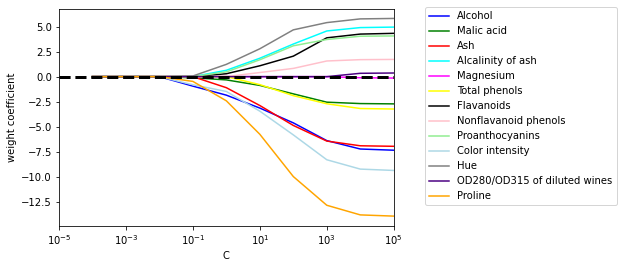

In [265]:
from sklearn.linear_model import LogisticRegression

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear', multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
#plt.savefig('images/04_07.png', dpi=300, 
#            bbox_inches='tight', pad_inches=0.2)
plt.show()

從上圖大約看一下，用C=10^-2到10^2次方之間，看model的training accuracy，決定最後C要取多少

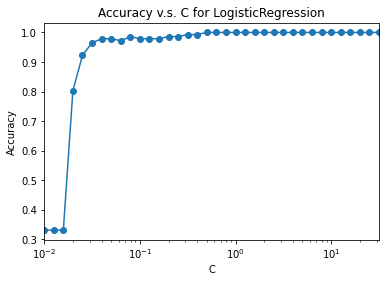

In [266]:
scores, params = [], []
for c in np.arange(-2, 2, 0.1):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear', multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    scores.append(lr.score(X_train_std, y_train))
    params.append(10**c)
scores = np.array(scores)    

plt.figure()
plt.title('Accuracy v.s. C for LogisticRegression')
plt.plot(params, scores, marker = 'o')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.xlim([10**(-2), 10**1.5])
plt.xscale('log')

從上圖看出C大概取0.6就可以了

### 決定n_iter要多少
定下C=0.6後，讓max_iter從15至50試試看accuracy，決定最後max_iter要取多少

Text(0, 0.5, 'Accuracy')

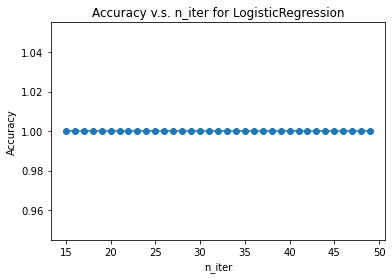

In [267]:
scores, params = [], []
for c in np.arange(15, 50, 1):
    lr = LogisticRegression(penalty='l1', C=0.6, solver='liblinear', multi_class='ovr', random_state=0, max_iter = c)
    lr.fit(X_train_std, y_train)
    scores.append(lr.score(X_train_std, y_train))
    params.append(c)
scores = np.array(scores)    

plt.figure()
plt.title('Accuracy v.s. n_iter for LogisticRegression')
plt.plot(params, scores, marker = 'o')
plt.xlabel('n_iter')
plt.ylabel('Accuracy')

由上圖可知，number of iteration取15就可以了

### Train model
當solver = 'liblinear'、penalty = 'l1'、max_iter = 15及C = 0.6時，training accuracy可達到差不多1，就用這些參數去train model

In [268]:
lr = LogisticRegression(penalty='l1', C=0.6, solver='liblinear', multi_class='ovr', random_state=0, max_iter = 15)
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)
error = (y_test != y_pred).sum()
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))
print('Misclassified examples: %d' % error)
if (error > 0):
    for i in range(1,36):
        if (y_test[i] != y_pred[i]):
            print(X[i, :])

Training accuracy: 1.0
Test accuracy: 0.9722222222222222
Misclassified examples: 1
[1.386e+01 1.350e+00 2.270e+00 1.600e+01 9.800e+01 2.980e+00 3.150e+00
 2.200e-01 1.850e+00 7.220e+00 1.010e+00 3.550e+00 1.045e+03]


### Result
training accuracy可達到100%，test data則會錯1筆，accuracy為97.22%  
***

## <font color="green">2.Support Vector Machine<font>
因為共有13個features及3種labels，他們的分布可能為nonlinear，所以kernel先選rbf試試看效果，C一樣取0.6

### 決定gamma要多少
讓gamma從0.01至30.1試試看accuracy，決定最後gamma要取多少

Text(0, 0.5, 'Accuracy')

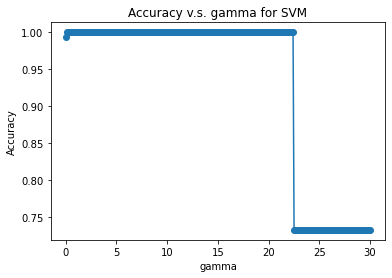

In [269]:
scores, params = [], []
for c in np.arange(0.01, 30.1, 0.1):
    svm = SVC(kernel='rbf', C=0.6, random_state=1, gamma=c)
    svm.fit(X_train_std, y_train)
    scores.append(svm.score(X_train_std, y_train))
    params.append(c)
scores = np.array(scores)    

plt.figure()
plt.title('Accuracy v.s. gamma for SVM')
plt.plot(params, scores, marker = 'o')
plt.xlabel('gamma')
plt.ylabel('Accuracy')

### Train model
當kernel = 'rbf'、gamma = 10及C = 0.6時，training accuracy可達到差不多1，就用這些參數去train model

In [270]:
svm = SVC(kernel='rbf', C=0.6, random_state=1, gamma=10)
svm.fit(X_train_std, y_train)

y_pred = svm.predict(X_test_std)
error = (y_test != y_pred).sum()
print('Training accuracy:', svm.score(X_train_std, y_train))
print('Test accuracy:', svm.score(X_test_std, y_test))
print('Misclassified examples: %d' % error)
if (error > 0):
    for i in range(1,36):
        if (y_test[i] != y_pred[i]):
            print(X[i, :])

Training accuracy: 1.0
Test accuracy: 0.3888888888888889
Misclassified examples: 22
[1.316e+01 2.360e+00 2.670e+00 1.860e+01 1.010e+02 2.800e+00 3.240e+00
 3.000e-01 2.810e+00 5.680e+00 1.030e+00 3.170e+00 1.185e+03]
[1.437e+01 1.950e+00 2.500e+00 1.680e+01 1.130e+02 3.850e+00 3.490e+00
 2.400e-01 2.180e+00 7.800e+00 8.600e-01 3.450e+00 1.480e+03]
[1.324e+01 2.590e+00 2.870e+00 2.100e+01 1.180e+02 2.800e+00 2.690e+00
 3.900e-01 1.820e+00 4.320e+00 1.040e+00 2.930e+00 7.350e+02]
[1.42e+01 1.76e+00 2.45e+00 1.52e+01 1.12e+02 3.27e+00 3.39e+00 3.40e-01
 1.97e+00 6.75e+00 1.05e+00 2.85e+00 1.45e+03]
[1.439e+01 1.870e+00 2.450e+00 1.460e+01 9.600e+01 2.500e+00 2.520e+00
 3.000e-01 1.980e+00 5.250e+00 1.020e+00 3.580e+00 1.290e+03]
[1.483e+01 1.640e+00 2.170e+00 1.400e+01 9.700e+01 2.800e+00 2.980e+00
 2.900e-01 1.980e+00 5.200e+00 1.080e+00 2.850e+00 1.045e+03]
[1.41e+01 2.16e+00 2.30e+00 1.80e+01 1.05e+02 2.95e+00 3.32e+00 2.20e-01
 2.38e+00 5.75e+00 1.25e+00 3.17e+00 1.51e+03]
[1.475e+01 

training accuracy可達到100%，但test accuracy只有38.89%，可能是gamma太大造成overfitting，所以我將gamma調小至1試試看

In [271]:
svm = SVC(kernel='rbf', C=0.6, random_state=1, gamma=1)
svm.fit(X_train_std, y_train)

y_pred = svm.predict(X_test_std)
error = (y_test != y_pred).sum()
print('Training accuracy:', svm.score(X_train_std, y_train))
print('Test accuracy:', svm.score(X_test_std, y_test))
print('Misclassified examples: %d' % error)
if (error > 0):
    for i in range(1,36):
        if (y_test[i] != y_pred[i]):
            print(X[i, :])

Training accuracy: 1.0
Test accuracy: 0.3888888888888889
Misclassified examples: 22
[1.316e+01 2.360e+00 2.670e+00 1.860e+01 1.010e+02 2.800e+00 3.240e+00
 3.000e-01 2.810e+00 5.680e+00 1.030e+00 3.170e+00 1.185e+03]
[1.437e+01 1.950e+00 2.500e+00 1.680e+01 1.130e+02 3.850e+00 3.490e+00
 2.400e-01 2.180e+00 7.800e+00 8.600e-01 3.450e+00 1.480e+03]
[1.324e+01 2.590e+00 2.870e+00 2.100e+01 1.180e+02 2.800e+00 2.690e+00
 3.900e-01 1.820e+00 4.320e+00 1.040e+00 2.930e+00 7.350e+02]
[1.42e+01 1.76e+00 2.45e+00 1.52e+01 1.12e+02 3.27e+00 3.39e+00 3.40e-01
 1.97e+00 6.75e+00 1.05e+00 2.85e+00 1.45e+03]
[1.439e+01 1.870e+00 2.450e+00 1.460e+01 9.600e+01 2.500e+00 2.520e+00
 3.000e-01 1.980e+00 5.250e+00 1.020e+00 3.580e+00 1.290e+03]
[1.483e+01 1.640e+00 2.170e+00 1.400e+01 9.700e+01 2.800e+00 2.980e+00
 2.900e-01 1.980e+00 5.200e+00 1.080e+00 2.850e+00 1.045e+03]
[1.41e+01 2.16e+00 2.30e+00 1.80e+01 1.05e+02 2.95e+00 3.32e+00 2.20e-01
 2.38e+00 5.75e+00 1.25e+00 3.17e+00 1.51e+03]
[1.475e+01 

training accuracy可達到100%，但test accuracy還是只有38.89%，可能是gamma還是太大造成overfitting，所以我再將gamma調小至0.2試試看

In [272]:
svm = SVC(kernel='rbf', C=0.6, random_state=1, gamma=0.2)
svm.fit(X_train_std, y_train)

y_pred = svm.predict(X_test_std)
error = (y_test != y_pred).sum()
print('Training accuracy:', svm.score(X_train_std, y_train))
print('Test accuracy:', svm.score(X_test_std, y_test))
print('Misclassified examples: %d' % error)
if (error > 0):
    for i in range(1,36):
        if (y_test[i] != y_pred[i]):
            print(X[i, :])

Training accuracy: 1.0
Test accuracy: 0.9722222222222222
Misclassified examples: 1
[1.324e+01 2.590e+00 2.870e+00 2.100e+01 1.180e+02 2.800e+00 2.690e+00
 3.900e-01 1.820e+00 4.320e+00 1.040e+00 2.930e+00 7.350e+02]


### Result
training accuracy可達到100%，test data則會錯1筆，accuracy為97.22%  
***

## 宣告Sequential Feature Selection Function
由於接下來的model沒有支援regularization且13個features太多了，可能會造成overfitting，所以我使用sequential feature slection方法，降低dataset的features數目

In [273]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

## <font color="green">3.Decision Tree<font>
criterion先試試看用gini    
<font color="red">decision tree的X data可以不用standardize過<font>

### 決定max_depth要多少
讓max_depth從1至15試試看accuracy，決定最後max_depth要取多少

Text(0, 0.5, 'Accuracy')

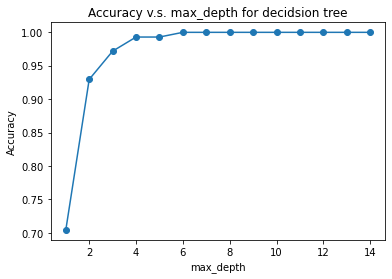

In [274]:
from sklearn.tree import DecisionTreeClassifier

scores, params = [], []
for c in np.arange(1, 15, 1):
    tree_model = DecisionTreeClassifier(criterion='gini', max_depth=c, random_state=1)
    tree_model.fit(X_train, y_train)
    scores.append(tree_model.score(X_train, y_train))
    params.append(c)
scores = np.array(scores)    

plt.figure()
plt.title('Accuracy v.s. max_depth for decidsion tree')
plt.plot(params, scores, marker = 'o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

從上圖我取max_depth = 6

### 用SBS降低features個數
先決定要降低至幾個features，再取最重要的前幾個出來

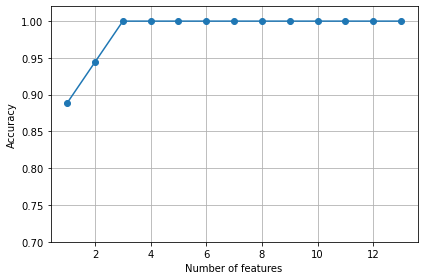

In [275]:
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=1)

# selecting features
sbs = SBS(tree_model, k_features=1)
sbs.fit(X_train, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

將features數降為3個

In [276]:
k3 = list(sbs.subsets_[10])
print(df.columns[1:][k3])

Index(['Alcohol', 'Flavanoids', 'Color intensity'], dtype='object')


### Train model
用criterion = "entropy"、max_depth = 6並選3個features 'Alcohol', 'Flavanoids', 'Color intensity'去train model

In [277]:
k3 = list(sbs.subsets_[10])
tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)
tree_model.fit(X_train[:, k3], y_train)

y_pred = tree_model.predict(X_test[:, k3])
error = (y_test != y_pred).sum()
print('Training accuracy:', tree_model.score(X_train[:, k3], y_train))
print('Test accuracy:', tree_model.score(X_test[:, k3], y_test))
print('Misclassified examples: %d' % error)
if (error > 0):
    for i in range(1,36):
        if (y_test[i] != y_pred[i]):
            print(X[i, :])

Training accuracy: 1.0
Test accuracy: 0.9722222222222222
Misclassified examples: 1
[1.387e+01 1.900e+00 2.800e+00 1.940e+01 1.070e+02 2.950e+00 2.970e+00
 3.700e-01 1.760e+00 4.500e+00 1.250e+00 3.400e+00 9.150e+02]


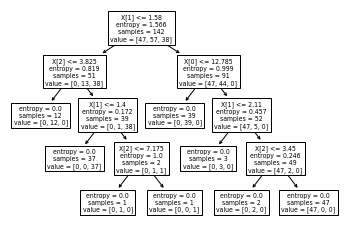

In [278]:
from sklearn import tree

tree.plot_tree(tree_model)
plt.show()

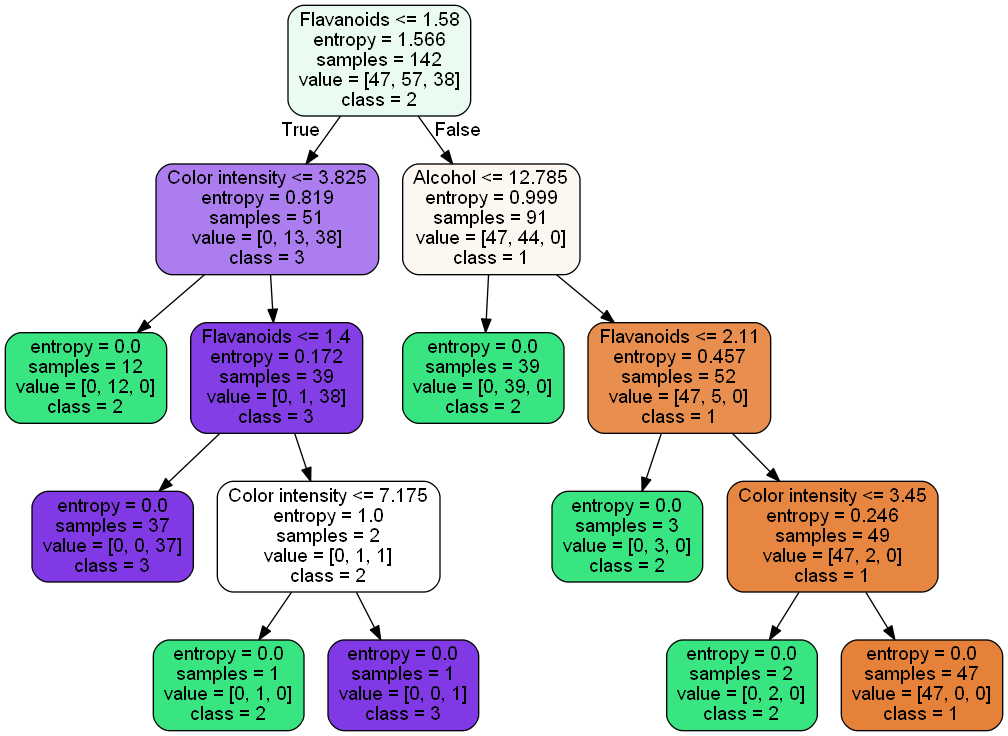

In [279]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image

dot_data = export_graphviz(tree_model,
                           filled=True, 
                           rounded=True,
                           class_names=['1', 
                                        '2',
                                        '3'],
                           feature_names=['Alcohol',                                          
                                          'Flavanoids',
                                          'Color intensity'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png')
Image(filename='tree.png', width=600)

### Result
training accuracy為100%，test accuracy為97.22%，則會錯1筆  
***

## <font color="green">4.Random Forest<font>
criterion先試試看用entropy    
<font color="red">random forest的X data可以不用standardize過<font>

### 決定n_estimators要多少
讓n_estimators從1至25試試看accuracy，決定最後n_estimators要取多少

Text(0, 0.5, 'Accuracy')

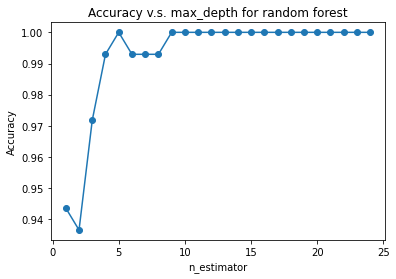

In [280]:
from sklearn.ensemble import RandomForestClassifier

scores, params = [], []
for c in np.arange(1, 25, 1):
    forest = RandomForestClassifier(criterion='gini',n_estimators=c, random_state=1, n_jobs=-1)
    forest.fit(X_train, y_train)
    scores.append(forest.score(X_train, y_train))
    params.append(c)
scores = np.array(scores)    

plt.figure()
plt.title('Accuracy v.s. max_depth for random forest')
plt.plot(params, scores, marker = 'o')
plt.xlabel('n_estimator')
plt.ylabel('Accuracy')

由上圖取n_estimator = 9

### 用SBS降低features個數
先決定要降低至幾個features，再取最重要的前幾個出來

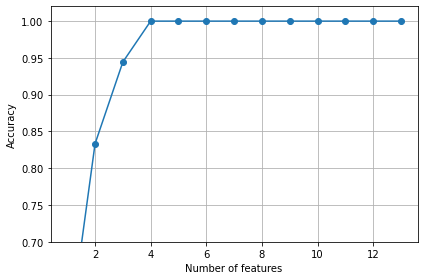

In [281]:
forest = RandomForestClassifier(criterion='gini',n_estimators=9, random_state=1, n_jobs=-1)

# selecting features
sbs = SBS(forest, k_features=1)
sbs.fit(X_train, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

將features數降為4個

In [282]:
k3 = list(sbs.subsets_[9])
print(df.columns[1:][k3])

Index(['Malic acid', 'Magnesium', 'OD280/OD315 of diluted wines', 'Proline'], dtype='object')


### Train model
用n_estimator = 9並選4個features 'Malic acid', 'Magnesium', 'OD280/OD315 of diluted wines', 'Proline'去train model

In [283]:
forest = RandomForestClassifier(criterion='gini',n_estimators=9, random_state=1, n_jobs=-1)
forest.fit(X_train[:, k3], y_train)

y_pred = forest.predict(X_test[:, k3])
error = (y_test != y_pred).sum()
print('Training accuracy:', forest.score(X_train[:, k3], y_train))
print('Test accuracy:', forest.score(X_test[:, k3], y_test))
print('Misclassified examples: %d' % error)
if (error > 0):
    for i in range(1,36):
        if (y_test[i] != y_pred[i]):
            print(X[i, :])

Training accuracy: 1.0
Test accuracy: 0.9444444444444444
Misclassified examples: 2
[1.324e+01 2.590e+00 2.870e+00 2.100e+01 1.180e+02 2.800e+00 2.690e+00
 3.900e-01 1.820e+00 4.320e+00 1.040e+00 2.930e+00 7.350e+02]
[1.406e+01 1.630e+00 2.280e+00 1.600e+01 1.260e+02 3.000e+00 3.170e+00
 2.400e-01 2.100e+00 5.650e+00 1.090e+00 3.710e+00 7.800e+02]


### Result
training accuracy為100%，test accuracy為94.44%，test data錯2筆   
***

## k-Nearest Neighbor
先試試看計算距離方式用p = 2、metric = 'minkowski'    

### 決定n_neighbors要多少
讓neighborsh從1至50試試看accuracy，決定最後n_neighbors要取多少

Text(0, 0.5, 'Accuracy')

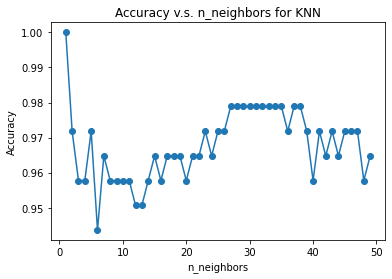

In [284]:
from sklearn.neighbors import KNeighborsClassifier

scores, params = [], []
for c in np.arange(1, 50, 1):
    knn = KNeighborsClassifier(n_neighbors=c, p=2, metric='minkowski')
    knn.fit(X_train_std, y_train)
    scores.append(knn.score(X_train_std, y_train))
    params.append(c)
scores = np.array(scores)    

plt.figure()
plt.title('Accuracy v.s. n_neighbors for KNN')
plt.plot(params, scores, marker = 'o')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')

由上圖可以看出當n_neighbors = 1時，accuracy為最高(100%)，當n_neighbors上升時，accuracy整體趨勢是下降的，但中間有震盪  
我們先試試看用n_neighbors = 1去train model，看test accuracy效果如何

### 用SBS降低features個數
先決定要降低至幾個features，再取最重要的前幾個出來

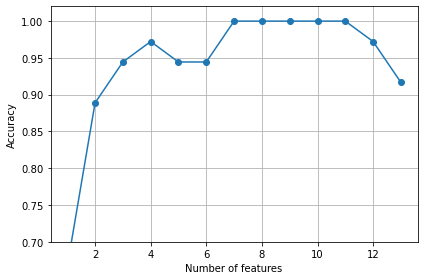

In [285]:
knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

將features數降為7個

In [286]:
k3 = list(sbs.subsets_[6])
print(df.columns[1:][k3])

Index(['Malic acid', 'Alcalinity of ash', 'Proanthocyanins', 'Color intensity',
       'Hue', 'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')


### Train model
用n_neighbors = 1並選7個features 'Malic acid',  'Alcalinity of ash',  'Proanthocyanins',  'Color intensity', 'Hue',   'OD280/OD315 of diluted wines',  'Proline'去train model

In [287]:
knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
knn.fit(X_train_std[:, k3], y_train)

y_pred = knn.predict(X_test_std[:, k3])
error = (y_test != y_pred).sum()
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))
print('Misclassified examples: %d' % error)
if (error > 0):
    for i in range(1,36):
        if (y_test[i] != y_pred[i]):
            print(X[i, :])

Training accuracy: 1.0
Test accuracy: 0.9444444444444444
Misclassified examples: 2
[1.387e+01 1.900e+00 2.800e+00 1.940e+01 1.070e+02 2.950e+00 2.970e+00
 3.700e-01 1.760e+00 4.500e+00 1.250e+00 3.400e+00 9.150e+02]


### Result
training accuracy為100%，test accuracy為94.44%，test data錯2筆  
原本以為取n_neighbors=1，可能會有overfitting產生，導致test accuracy不好，但實驗結果是test accuracy還不錯    
***

## 討論
* 五種models效果都不錯，training accuracy都可以達到100%，而test accuracy也都在90%以上
* 經過上次作業亂調參數，調了很久但效果都不是很好的教訓後，這次我學會在確定參數要設多少前，先劃一些圖來輔助判斷，這樣心裡才有個底，可以很快且精準的設定參數
* 在這次作業中，當一個model有多個參數要設定時，我都是依序每次固定1個參數，看在當時那個參數為多少是最佳狀態，這種做法是有可能會錯過一些更好的參數設定狀況，因為照理來說應該有很多很多種排列組合，而不是一次定下一個參數然後再進行另一個參數。目前看起來這種作法雖有小漏洞，但效果也還不錯，train出來的model accuracy都滿高的